In [8]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, OutputLoader
from superfv.initial_conditions import sedov
from teyssier.sedov import sedovana

In [9]:
T = 0.8
N = 100
gamma = 1.4
overwrite = False

base_path = "../../out/sedov1d/"

In [10]:
# analytical solution for plotting
dim = 1
E0 = 1
rho0 = 1

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(0.97306051566207)


In [11]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
musclhancock = dict(p=1, MUSCL=True, **common)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="moncen",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

configs = {
    "MUSCL-Hancock": dict(MUSCL_limiter="moncen", **musclhancock),
    "ZS3": dict(p=3, **apriori),
    "ZS7": dict(p=7, **apriori),
    "MM3/1rev/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori1),
    "MM7/1rev/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori1),
    "MM3/1rev/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori1),
    "MM7/1rev/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori1),
    "MM3/1rev/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori1),
    "MM7/1rev/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori1),
    "MM3/1rev/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori1),
    "MM7/1rev/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori1),
    "MM3/1rev/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori1),
    "MM7/1rev/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori1),
    "MM3/1rev/rtol_1e-3": dict(p=3, NAD_rtol=1e-3, **aposteriori1),
    "MM7/1rev/rtol_1e-3": dict(p=7, NAD_rtol=1e-3, **aposteriori1),
    "MM3/1rev/rtol_1e-5": dict(p=3, NAD_rtol=1e-5, **aposteriori1),
    "MM7/1rev/rtol_1e-5": dict(p=7, NAD_rtol=1e-5, **aposteriori1),
    "MM3/1rev/rtol_0": dict(p=3, NAD_rtol=0, **aposteriori1),
    "MM7/1rev/rtol_0": dict(p=7, NAD_rtol=0, **aposteriori1),
    "MM3/2revs/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori2),
    "MM7/2revs/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori2),
    "MM3/2revs/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori2),
    "MM7/2revs/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori2),
    "MM3/2revs/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori2),
    "MM7/2revs/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori2),
    "MM3/3revs/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori3),
    "MM7/3revs/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori3),
    "MM3/3revs/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori3),
    "MM7/3revs/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori3),
    "MM3/3revs/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori3),
    "MM7/3revs/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori3),
    "MM3/3revs/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori3),
    "MM7/3revs/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori3),
    "MM3/3revs/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori3),
    "MM7/3revs/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori3),
    "MM3/3revs/rtol_0": dict(p=3, NAD_rtol=0, **aposteriori3),
    "MM7/3revs/rtol_0": dict(p=7, NAD_rtol=0, **aposteriori3),
}

In [12]:
sims = {}
for name, config in configs.items():
    sim_path = f"{base_path}{name}"

    if not overwrite:
        try:
            sim = OutputLoader(sim_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

        # try to read 'error.txt'
        try:
            with open(f"{sim_path}/error.txt", "r") as f:
                print(f"Skipping simulation {name} due to previous error.")
            continue
        except FileNotFoundError:
            pass

    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(sedov, P0=1e-5, h=1 / N, gamma=gamma),
        gamma=gamma,
        bcx=("reflective", "free"),
        nx=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=sim_path,
            allow_overshoot=True,
            overwrite=overwrite,
            max_steps=10000,
        )
    except Exception as e:
        print(f"Simulation {name} failed with error: {e}")
        with open(f"{sim_path}/error.txt", "w") as f:
            f.write(str(e))
        continue

    sims[name] = sim

Successfully read simulation output from "../../out/sedov1d/MUSCL-Hancock"
Successfully read simulation output from "../../out/sedov1d/ZS3"
Successfully read simulation output from "../../out/sedov1d/ZS7"
Successfully read simulation output from "../../out/sedov1d/MM3/1rev/no_NAD"
Successfully read simulation output from "../../out/sedov1d/MM7/1rev/no_NAD"
Successfully read simulation output from "../../out/sedov1d/MM3/1rev/rtol_1e1"
Successfully read simulation output from "../../out/sedov1d/MM7/1rev/rtol_1e1"
Successfully read simulation output from "../../out/sedov1d/MM3/1rev/rtol_1e0"
Successfully read simulation output from "../../out/sedov1d/MM7/1rev/rtol_1e0"
Successfully read simulation output from "../../out/sedov1d/MM3/1rev/rtol_1e-1"
Successfully read simulation output from "../../out/sedov1d/MM7/1rev/rtol_1e-1"
Successfully read simulation output from "../../out/sedov1d/MM3/1rev/rtol_1e-2"
Successfully read simulation output from "../../out/sedov1d/MM7/1rev/rtol_1e-2"
Succe

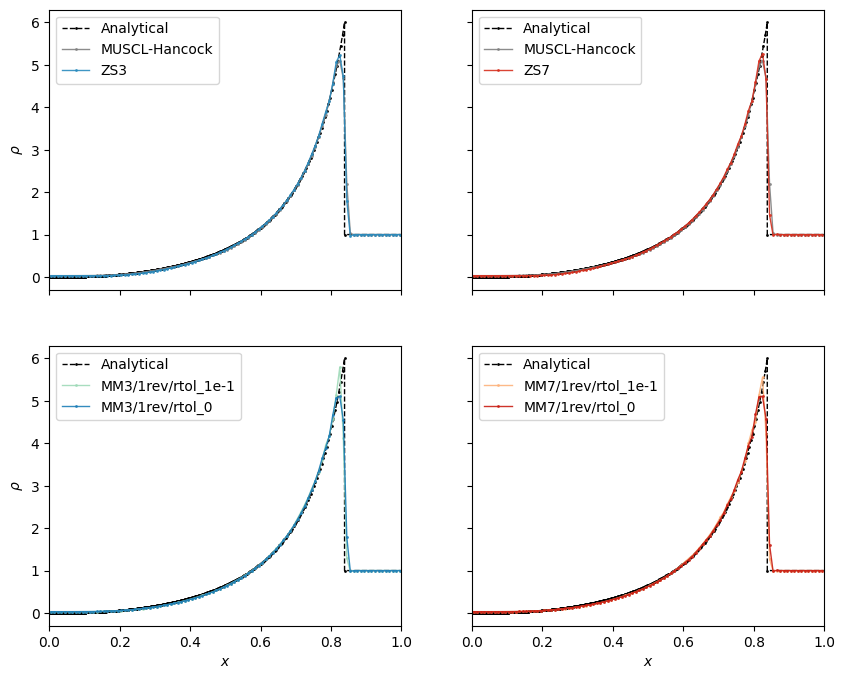

In [13]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[1, 0].set_xlabel(r"$x$")
axs[1, 1].set_xlabel(r"$x$")
axs[0, 0].set_ylabel(r"$\rho$")
axs[1, 0].set_ylabel(r"$\rho$")
axs[0, 0].set_xlim(0, 1)

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")
common_style = dict(linewidth=1, markersize=1, marker="o", mfc="none")


def plot(name, ax, v, style=dict()):
    plot_1d_slice(
        sims[name],
        ax,
        v,
        label=name,
        alpha=0.9,
        **common_style,
        **style,
    )


axs[0, 0].plot(r, d, label="Analytical", color="k", linestyle="--", **common_style)
plot("MUSCL-Hancock", axs[0, 0], "rho", dict(color="grey"))
plot("ZS3", axs[0, 0], "rho", dict(color=cmap1(0.75)))

axs[0, 1].plot(r, d, label="Analytical", color="k", linestyle="--", **common_style)
plot("MUSCL-Hancock", axs[0, 1], "rho", dict(color="grey"))
plot("ZS7", axs[0, 1], "rho", dict(color=cmap2(0.75)))

axs[1, 0].plot(r, d, label="Analytical", color="k", linestyle="--", **common_style)
plot("MM3/1rev/rtol_1e-1", axs[1, 0], "rho", dict(color=cmap1(0.4)))
plot("MM3/1rev/rtol_0", axs[1, 0], "rho", dict(color=cmap1(0.8)))

axs[1, 1].plot(r, d, label="Analytical", color="k", linestyle="--", **common_style)
plot("MM7/1rev/rtol_1e-1", axs[1, 1], "rho", dict(color=cmap2(0.4)))
plot("MM7/1rev/rtol_0", axs[1, 1], "rho", dict(color=cmap2(0.8)))

axs[0, 0].legend(loc="upper left")
axs[0, 1].legend(loc="upper left")
axs[1, 0].legend(loc="upper left")
axs[1, 1].legend(loc="upper left")

In [14]:
fig.savefig("sedov-1d.pdf")